In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay


In [2]:
# Load dataset
def load_data(filepath):
    """
    Load dataset from a CSV file.
    """
    return pd.read_csv(filepath)

# Prepare product data
def prepare_product_data(data):
    """
    Prepare product data by creating a unique product ID for each product and merging with the original data.
    """
    Product = data[['item_name', 'item_brand', 'item_main_category', 'item_sub_category']].drop_duplicates()
    Product.insert(0, 'Product_id', range(1, 1 + len(Product)))
    return pd.merge(data, Product, on=['item_name', 'item_brand', 'item_main_category', 'item_sub_category'], how='inner')

# Aggregate data
def aggregate_data(data):
    """
    Aggregate sales data by transaction date and product ID.
    """
    return data.groupby(['transaction_date', 'Product_id']).agg({
        'item_quantity': 'sum',
        'return_quantity': 'sum',
        'item_coupon': 'sum'
    }).reset_index()

# Plot data
def plot_data(data, title, xlabel, ylabel):
    """
    Plot item quantities over time.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(data['transaction_date'], data['item_quantity'], linestyle='-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Normalize data
def normalize_data(data):
    """
    Normalize the dataset using StandardScaler.
    """
    scaler = StandardScaler()
    scaler = scaler.fit(data)
    data_scaled = scaler.transform(data)
    return data_scaled, scaler

# Prepare LSTM data
def prepare_lstm_data(data, n_past, n_future):
    """
    Prepare data for LSTM input by creating sequences of past and future data.
    """
    trainX, trainY = [], []
    for i in range(n_past, len(data) - n_future + 1):
        trainX.append(data[i - n_past:i, :])
        trainY.append(data[i + n_future - 1:i + n_future, 0])
    
    trainX, trainY = np.array(trainX), np.array(trainY)
    return trainX, trainY

# Build LSTM model
def build_model(input_shape):
    """
    Build and compile the LSTM model.
    """
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Train LSTM model
def train_model(model, trainX, trainY):
    """
    Train the LSTM model with the given data.
    """
    history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)
    
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return model

# Make predictions
def make_predictions(model, data, scaler, n_days_for_prediction, train_dates):
    """
    Make future sales predictions using the trained model.
    """
    # Make predictions
    prediction = model.predict(data[-n_days_for_prediction:])
    
    # Repeat the prediction to match the original feature dimensions
    # Repeat along the last dimension
    prediction_copies = np.repeat(prediction, data.shape[2], axis=-1)
    
    # Perform inverse transformation
    y_pred_future = scaler.inverse_transform(prediction_copies)[:, 0]
    
    # Generate future dates for plotting
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    predict_period_dates = pd.date_range(list(train_dates)[-1], periods=n_days_for_prediction, freq=us_bd).tolist()
    
    return predict_period_dates, y_pred_future


# Plot forecast
def plot_forecast(original, predict_period_dates, y_pred_future):
    """
    Plot original data and forecasted data.
    """
    df_forecast = pd.DataFrame({'transaction_date': np.array(predict_period_dates), 'item_quantity': y_pred_future})
    df_forecast['transaction_date'] = pd.to_datetime(df_forecast['transaction_date'])
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=original, x='transaction_date', y='item_quantity', label='Original')
    sns.lineplot(data=df_forecast, x='transaction_date', y='item_quantity', label='Forecast')
    plt.title('Sales Forecast')
    plt.xlabel('Transaction Date')
    plt.ylabel('Item Quantity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return df_forecast


In [3]:
# Load and
Table2 = load_data('Dataset.csv')
Table2

,transaction_date,item_id,transaction_id,item_name,item_brand,item_main_category,item_sub_category,item_gender,item_coupon,item_price,return_quantity,item_quantity,transaction_revenue,item_revenue_NOCOUP,refund_value,cost_goods_sold,distribution_cost
0,2020-07-05,878967,1007325426,watch,Swarovski,Accessories,Watches,Women,0.000000,105.00,0,1,105.00,105.00,NaN,69.3,5.24
1,2020-03-01,893039,1005954178,scarf,Pierre Cardin,Accessories,Scarves & Winter Hats & Gloves,Men,0.000000,5.00,0,1,5.00,5.00,NaN,2.9,5.24
2,2020-04-25,579415,1006478692,bodysuit,Prism,Suits & Tops,Dresses & Jumpsuits,Children & Toddlers,0.000000,3.00,0,4,13.50,12.00,NaN,4.4,20.96
3,2020-02-05,908195,5702250,scarf,Prism,Accessories,Scarves & Winter Hats & Gloves,Men,0.000000,10.00,0,1,10.00,10.00,NaN,2.8,5.24
4,2020-05-04,692379,1006556056,hat,Prism,Accessories,Headwear,Children & Toddlers,0.000000,2.00,0,2,22.00,4.00,NaN,1.6,10.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818222,2021-06-14,1012611,1012702993,lifestyle shoes,adidas,Shoes & Bags,Shoes,Women,0.000000,26.25,0,1,26.25,26.25,NaN,17.6,5.24
818223,2020-08-29,941502,1007778046,lifestyle shoes,Prism,Shoes & Bags,Shoes,Men,0.000000,25.00,1,1,25.00,25.00,25.0,0.0,5.24
818224,2021-12-27,1051208,1015290976,lifestyle shoes,Prism,Shoes & Bags,Shoes,Women,0.000000,20.00,1,1,20.00,20.00,20.0,0.0,5.24
818225,2022-05-04,1074910,1017281947,lifestyle shoes,Hummel,Shoes & Bags,Shoes,Women,0.000000,20.00,0,1,20.00,20.00,NaN,12.4,5.24


In [4]:
# prepare data
Table = prepare_product_data(Table2)
Table_L = aggregate_data(Table)
Table_L

,transaction_date,Product_id,item_quantity,return_quantity,item_coupon
0,2020-01-01,1,1,0,0.00
1,2020-01-01,4,2,0,0.00
2,2020-01-01,11,12,3,0.00
3,2020-01-01,24,1,0,0.00
4,2020-01-01,36,1,0,0.00
...,...,...,...,...,...
210152,2022-08-17,2526,3,0,0.00
210153,2022-08-17,2531,2,0,0.15
210154,2022-08-17,2532,3,0,0.15
210155,2022-08-17,2536,4,0,0.00


C:\Users\ornel\AppData\Local\Temp\ipykernel_19480\4108645067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transaction_date'] = pd.to_datetime(df['transaction_date'])


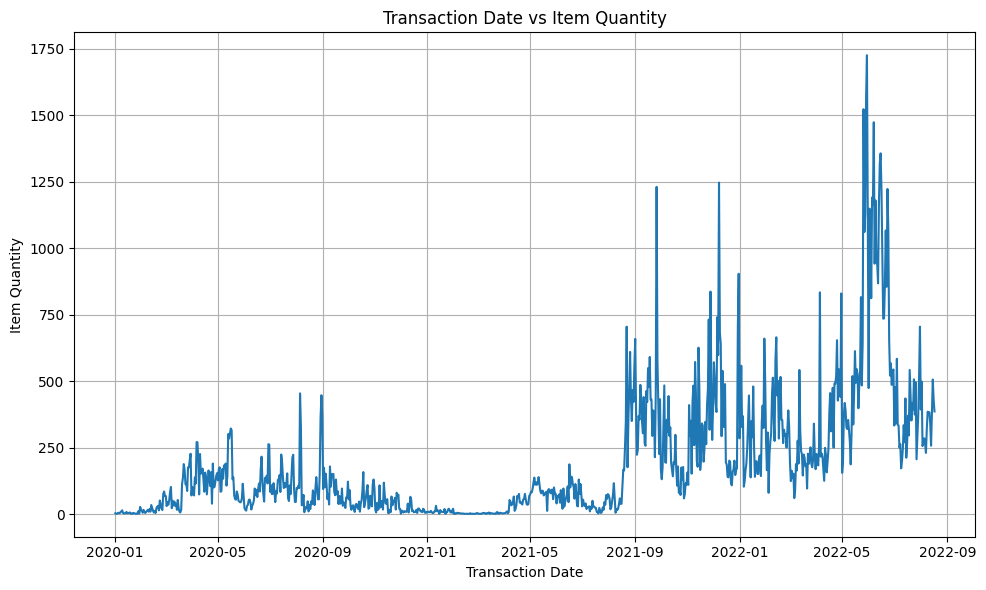

In [5]:
# Filter specific product data
df = Table_L[Table_L['Product_id'] == 2081]
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Plot initial data
plot_data(df, 'Transaction Date vs Item Quantity', 'Transaction Date', 'Item Quantity')


In [6]:
# Normalize and prepare data for LSTM
df_for_training = df[['item_quantity', 'return_quantity', 'item_coupon']]
df_for_training_scaled, scaler = normalize_data(df_for_training)
trainX, trainY = prepare_lstm_data(df_for_training_scaled, n_past=14, n_future=1)


Epoch 1/10
52/52 [==============================] - 5s 20ms/step - loss: 0.2830 - val_loss: 2.6142
Epoch 2/10
52/52 [==============================] - 1s 10ms/step - loss: 0.2085 - val_loss: 1.7627
Epoch 3/10
52/52 [==============================] - 1s 11ms/step - loss: 0.1949 - val_loss: 1.3655
Epoch 4/10
52/52 [==============================] - 1s 11ms/step - loss: 0.1903 - val_loss: 1.9423
Epoch 5/10
52/52 [==============================] - 1s 11ms/step - loss: 0.1895 - val_loss: 1.8285
Epoch 6/10
52/52 [==============================] - 1s 12ms/step - loss: 0.1836 - val_loss: 2.1044
Epoch 7/10
52/52 [==============================] - 1s 11ms/step - loss: 0.1846 - val_loss: 2.1541
Epoch 8/10
52/52 [==============================] - 1s 10ms/step - loss: 0.1807 - val_loss: 1.8909
Epoch 9/10
52/52 [==============================] - 1s 10ms/step - loss: 0.1709 - val_loss: 1.8429
Epoch 10/10
52/52 [==============================] - 1s 10ms/step - loss: 0.1766 - val_loss: 1.7496


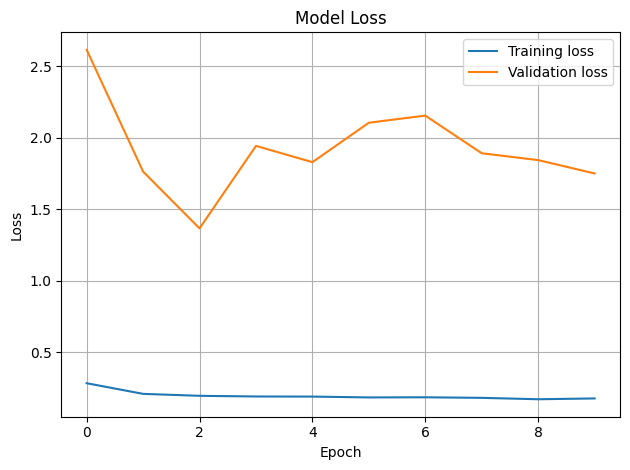

1/1 [==============================] - 0s 374ms/step


In [7]:
# Build, train, and predict with the model
model = build_model((trainX.shape[1], trainX.shape[2]))
model = train_model(model, trainX, trainY)

# Make predictions
predict_period_dates, y_pred_future = make_predictions(model, trainX, scaler, n_days_for_prediction=30, train_dates=df['transaction_date'])


C:\Users\ornel\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ornel\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ornel\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ornel\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

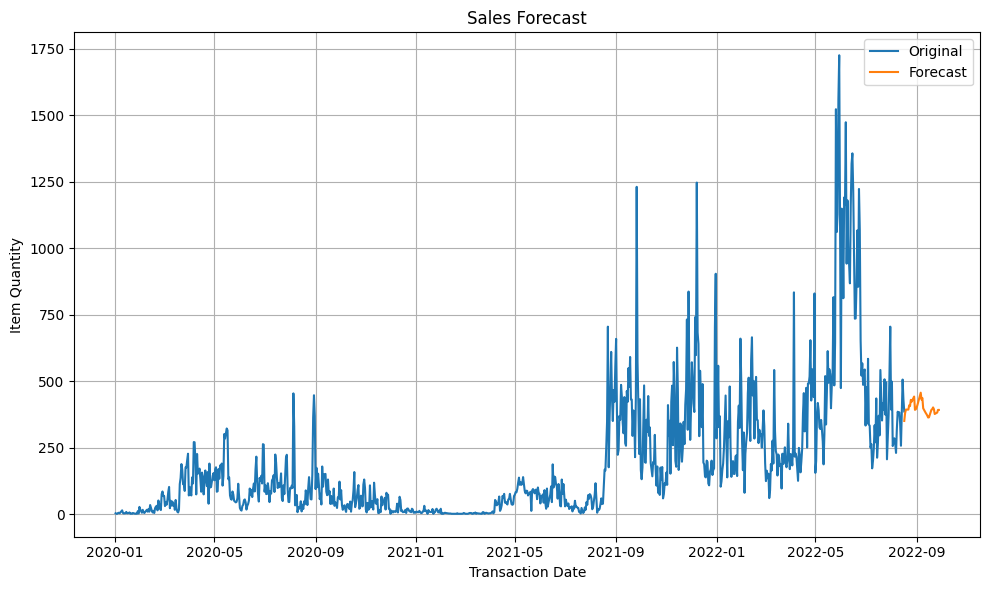

Average Forecasted Quantity: 397.42706


In [8]:
# Plot forecast
df_forecast = plot_forecast(df[['transaction_date', 'item_quantity']], predict_period_dates, y_pred_future)

# Calculate and print average forecasted quantity
avg_quantity = df_forecast['item_quantity'].mean()
print('Average Forecasted Quantity:', avg_quantity)
